In [1]:
%%capture
import matplotlib.pyplot as plt
import numpy as np
import cv2

try: cv2.setNumThreads(0)
except: pass
from caiman import movie
import os
# %matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
from itertools import product
from collections import OrderedDict

from sys import path as syspath
syspath.append(os.path.expanduser("~/srdjan_functs/"))

from physio_def_1 import *
from matplotlib.colors import LogNorm

from numeric import *
from collections import Counter

import plotly_express as px

In [61]:
# some definitions
def climb(x,blurredWeights,diag=True,min_gradient = 0):
    dims = blurredWeights.shape
    # x = (60,60)
    x = x+(blurredWeights[x[0],x[1]],)
    xs = [x]
    for i in range(100):
        vs = []
        for di,dj in product([-1,0,1],[-1,0,1]):
            if not diag:
                if di*dj!=0: continue
            i,j = x[0]+di,x[1]+dj
            if i<0 or i>=dims[0] or j<0 or j>=dims[1]:
                continue
            vs += [(i,j,blurredWeights[i,j])]
        x1 = vs[np.argmax(vs,axis=0)[-1]]
        dx = x1[-1]-x[-1]
        if dx<=0:
            break
        elif dx<=min_gradient:
            return (None,)
        else:
            x = x1
            xs += [x]
    return x[:2]

def crawlDict(image, th=-np.inf, diag=False, min_gradient=0):
    A_ = [(i,j)+climb((i,j),image,diag=diag,min_gradient=min_gradient) for i,j in product(range(image.shape[0]),range(image.shape[1])) if image[i,j]>th]
    A_ = [el for el in A_ if el[-1] is not None]
    B_ = OrderedDict()
    for (i0,j0,i1,j1) in A_:
        if (i1,j1) not in B_:
            B_[(i1,j1)] = []
        B_[(i1,j1)] += [(i0,j0)]
    return B_

def edges2nodes(x,start=0,direction=1):
    if np.array(x[0]).shape != (2,2):
        x = [(el[:2],el[2:]) for el in x]
    nodes = list(x[start][::direction])

    for i in range(len(x)-1):
        nexts = [edge for edge in x if (edge[0]==nodes[-1] or edge[1]==nodes[-1])]
        for cand in np.unique(sum(nexts,()),axis=0):
            if tuple(cand) not in nodes:
                nodes += [tuple(cand)]
    return nodes

class Regions:
    def __init__(self, image, th=-np.inf, diag=False, min_gradient=0):
        from pandas import DataFrame
        self.image = image
        A_ = [(i,j)+climb((i,j),image,diag=diag,min_gradient=min_gradient) for i,j in product(range(image.shape[0]),range(image.shape[1])) if image[i,j]>th]
        A_ = [el for el in A_ if el[-1] is not None]
        B_ = OrderedDict()
        for (i0,j0,i1,j1) in A_:
            if (i1,j1) not in B_:
                B_[(i1,j1)] = []
            B_[(i1,j1)] += [(i0,j0)]
        self.df = DataFrame(OrderedDict([
            ("peak",list(B_.keys())),
            ("pixels",list(B_.values()))
        ]))
        self.df["peakValue"] = [image[p] for p in B_]
        self.update()

    def update(self, movie_=None):
        self.df["size"] = self.df["pixels"].apply(len)
        self.calcEdgeIds()
        self.calcEdges()
        self.df["boundary"] = [edges2nodes(self.df["edges"][j]) for j in self.df.index]
        self.calcNNmap()
        if movie_ is not None:
            self.calcTraces(movie_)
    
    @property
    def peak(self):
        return self.df["peak"]
    @property
    def pixels(self):
        return self.df["pixels"]
    @property
    def edges(self):
        return self.df["edges"]
    
    def calcEdgeIds(self):
        dround = np.vstack([(-1,-1),(-1, 1),( 1, 1),( 1,-1),(-1,-1)])
        dedges = []
        for el in zip(dround[:-1],dround[1:]):
            el = np.array(el)+1
            el = np.vstack(sorted(el,key=np.linalg.norm))-1
            dedges += [el*.5]
        dedges = np.stack(dedges)
        edgeID = OrderedDict()
        for k,pixelSet in zip(self.peak,self.pixels):
            for x,y in pixelSet:
                edges = dedges.copy()
                edges[...,0] += x
                edges[...,1] += y
                for edge in edges.reshape((-1,4)):
                    edge = tuple(edge)
                    if edge not in edgeID:
                        edgeID[edge] = []
                    edgeID[edge] += [k]
                    if len(edgeID[edge])==2 and edgeID[edge][0]==edgeID[edge][1]:
                        del edgeID[edge]
        self.edgeIDs = edgeID
    
    def calcEdges(self):
        invEdgeID = OrderedDict()
        if "edgeIDs" not in locals():
            self.calcEdgeIds()
        for k in self.edgeIDs:
            for p in self.edgeIDs[k]:
                if p not in invEdgeID:
                    invEdgeID[p] = []
                invEdgeID[p] += [k]
#         self.edges = OrderedDict([(p,invEdgeID[p]) for p in self.peaks])
        self.df["edges"] = [invEdgeID[p] for p in self.peak]
    
#     @property
    def getEdges(self,ix=None):
        if ix is None:
            out = sum(self.edges,[])
        else:
            out = sum(self.df.loc[ix,"edges"],[])
        out = np.unique(out,axis=0)
        return out
    
    def plotEdges(self, ix=None, ax=None, image =True, imkw_args = {"cmap":"Greys_r"}, separate=False):
        from matplotlib.colors import LogNorm
        if ax is None:
            ax = plt.subplot(111)
        if image:
            ax.imshow(self.image,norm=LogNorm(),**imkw_args)
        if separate:
            for i in ix:
                c = "C%i"%(i%10)
                for el in self.df.loc[i,"edges"]:
                    y,x = np.array(el).reshape((2,2)).T
                    ax.plot(x,y,lw=.8,c=c)
        else:
            for el in self.getEdges(ix=ix):
                y,x = np.array(el).reshape((2,2)).T
                ax.plot(x,y,"k",lw=.5)
            
            
    def plotPeaks(self, ix=None, ax=None, image=False, ms=1, labels=False):
        if ax is None:
            ax = plt.subplot(111)
        if image:
            ax.imshow(self.image)
        if ix is None:
            peaks = self.df["peak"]
            sizes = self.df["size"]**.5*ms
        else:
            peaks = self.df.loc[ix,"peak"]
            sizes = self.df.loc[ix,"size"]**.5*ms
        for ms,p in zip(sizes,peaks):
            i = self.peak2idx[p]
            c = "C%i"%(i%10)
            ax.plot(*p[::-1],marker="o",mfc="none",ms=ms,c=c)
            if labels:
                ax.text(*p[::-1],s=str(i),color=c)
    
    def calcNNmap(self):
        from bidict import bidict
        peak2idx = bidict([(peak,j) for j,peak in zip(self.df.index,self.df.peak)])
        self.peak2idx = peak2idx
        neighborsMap = {k:[] for k in self.peak}
        for edge in self.edgeIDs:
            if len(self.edgeIDs[edge])>1:
                for e1,e2 in product(self.edgeIDs[edge],self.edgeIDs[edge]):
                    if e1==e2: continue
                    if e2 not in neighborsMap[e1]:
                        neighborsMap[e1] += [e2]
        self.df["neighbors"] = [[peak2idx[pp] for pp in neighborsMap[p]] for p in self.peak]
        self.df["Nneighbors"] = self.df["neighbors"].apply(len)
        
    def purge_lones(self,min_size=4):
        toDel = []
        for i in self.df.index:
            if self.df.loc[i,"size"]<min_size and self.df.loc[i,"Nneighbors"]==0:
                toDel += [i]
        self.df = self.df.drop(index=toDel)
        print ("deleted %i rois"%len(toDel))
    
    def calcTraces(self, movie_):
        traces = np.ones((len(self.df),len(movie_)))*np.nan
        for i,ix in enumerate(self.df.index):
            x = self.df.loc[ix,"pixels"]
            x = [ el[0] for el in x ] , [ el[1] for el in x ]
            traces[i] = movie_[ :, x[0], x[1] ].mean(axis=1)
        print (traces.shape, )
        self.df["trace"] = list(traces)
        
    def calcIntraCCs(self,movie_,diff=False,indices=None):
        intraCCs = []
        if indices is None:
            indices = self.df.index
        for roi in indices:
            if C.loc[roi,"size"]<1:
                intraCCs += [[np.nan]]
                continue
            trace = C.loc[roi,"trace"]
            pixels = C.loc[roi,"pixels"]
            size = len(pixels)
            indTraces = [movie_[(slice(None),) + px] for px in pixels]
            ccs = []
            for tr in indTraces:
                x,y = trace*size-tr, tr
                if diff:
                    x = np.diff(x)
                    y = np.diff(y)
                ccs += [np.corrcoef(x,y)[0,1]]
            intraCCs += [ccs]

        C.loc[indices,"intraCCs"] = intraCCs
#         del intraCCs

# Importing

In [3]:
npzFiles = [
#     "local_data/Sandra/2020_01_14/Experiment45b/Experiment45b_1_Series006.npz",
#     "local_data/Sandra/2020_01_14/Experiment45b/Experiment45b_2_Series007.npz",
#     "local_data/Sandra/2020_01_14/Experiment45b/Experiment45b_3_Series008.npz"
    "local_data/Sandra/2020_01_14/Experiment45c/Experiment45c_1_Series003.npz",
    "local_data/Sandra/2020_01_14/Experiment45c/Experiment45c_2_Series004.npz",
    
#     "local_data/testdir/Experiment38a_18_Series040.npz"
#     "local_data/testdir/Experiment38a_7_Series016.npz"
]
# npzFile = f"/Volumes/physio/team/slakrupnik/project/experiments/Sandra/{row.date}/{row.filename.split('_')[0]}/{row.filename}.npz"
metadata = pd.DataFrame([pd.read_csv(npzFile.replace("npz","txt")).loc[0] for npzFile in npzFiles])

In [4]:
if len(metadata)>1:
    assert metadata.X.std()==0
    assert metadata.Y.std()==0
    assert metadata.freq.std()/metadata.freq.mean()<1e-3
    print ((metadata["T"]/metadata["freq"]/60).sum(), "minutes")
    origFreq = metadata.freq.mean()
    metadata["T"] = metadata["T"].sum()
    metadata = pd.Series(metadata.iloc[0])
    metadata["freq"] = origFreq
else:
    metadata = metadata.iloc[0]
    origFreq = metadata.freq
    print (metadata["T"]/metadata.freq/60, "minutes")

48.652528681299614 minutes


In [5]:
baseName = getBaseName(npzFiles)

In [6]:
if os.path.isfile(baseName+"_motcor.npz"):
    npzFile = baseName+"_motcor.npz"
    npzFileHandle = np.load(npzFile)
    template = npzFileHandle["template"]
    m_orig = movie(npzFileHandle['data'])
else:
    orig_images = import_npz_files(npzFiles)
    m_orig = movie(orig_images.astype("float32"))
    del orig_images
m_orig.fr = origFreq

In [7]:
# time = np.arange(len(m_orig)).astype(np.float32)/metadata.freq
# allTrace = m_orig.mean(axis=(1,2))
# Nsatur = np.sum(m_orig>m_orig.max()-1, axis=(1,2))

# plt.plot(allTrace)
# plt.twinx()
# plt.plot(Nsatur,"C1",lw=.5)

In [46]:
def get_sep_th(blurredWeights,ax=None):
    from scipy.stats import gaussian_kde
    if ax is None:
        ax = plt.subplot(111)
    gkde = gaussian_kde(blurredWeights.flatten())
    h,edges,_ = ax.hist(blurredWeights.flatten(),100,histtype="step",density=True);
    bincenters = (edges[:-1]+edges[1:])/2
    gkde_vals = gkde.evaluate(bincenters)
    ax.plot(bincenters,gkde_vals)
    th = bincenters[list(crawlDict(-gkde_vals.reshape(-1,1)+gkde_vals.max()+1,).keys())[1][0]-2]
#     ax.axvline(th,color="r")
    return th

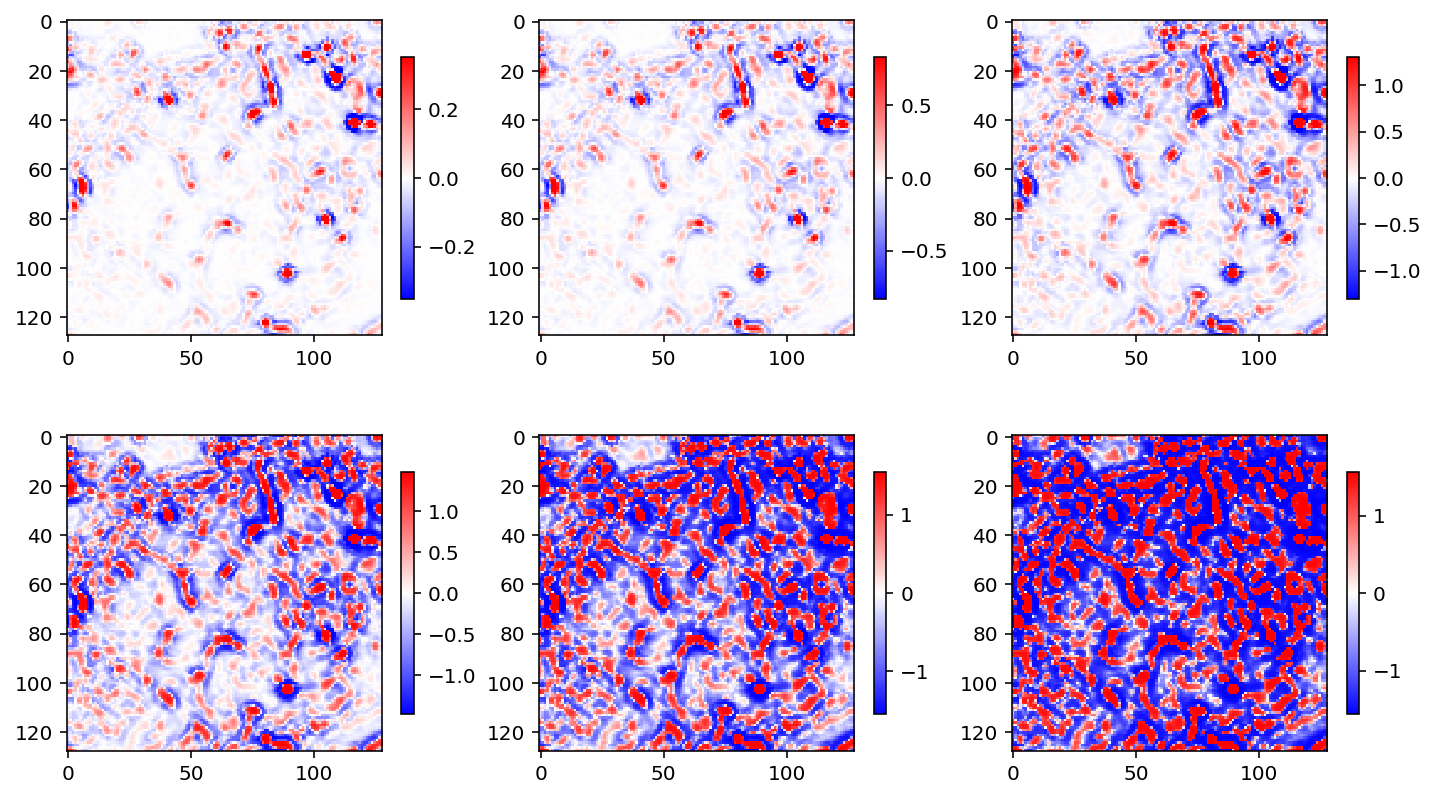

In [13]:
# Look at the template from CaImAn. Didn't figure out yet what it actually is, but seems useful
fig, axs = plt.subplots(2,3,figsize=(12,7))
for sc,ax in zip([1,3,10,30,100,300],axs.flat):
    x = np.arctan(sc*template)
    v = np.percentile(np.abs(x),99)*1
    im = ax.imshow(x,cmap="bwr", vmin=-v, vmax=v)
    plt.colorbar(im,ax=ax,shrink=.7)

In [ ]:
# prepare m_analys for faster analysis.
# (For final presentation we can always go back to original movie.)
m_analysis = m_orig.copy()

# First, introduce some gaussian blur
m_analysis.gaussian_blur_2D(3,3,.5,.5);

# Then, resample to lower frequency (for analyses downstream to go much faster)
newFreq = 3
n_rebin = int(m_orig.fr/newFreq)
m_analysis = rebin(m_analysis,n_rebin, norm=False)
m_analysis.fr = m_orig.fr/n_rebin

In [24]:
# sometimes it makes sense to debleach
m_debleached = m_analysis.copy()
m_debleached.debleach();

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/caiman/base/movies.py:535: UserWarning:

Casting the array to float32



In [26]:
%%capture
images = OrderedDict([
    ("template", template),
    
    ("cc_0"  ,      m_analysis.local_correlations(eight_neighbours=True,swap_dim=False)),
    ("std_0" ,      m_analysis.std(axis=0)),
    ("mean_0",      m_analysis.mean(axis=0)),
    
    ("cc_0_dbl"  ,  m_debleached.local_correlations(eight_neighbours=True,swap_dim=False)),
    ("std_0_dbl" ,  m_debleached.std(axis=0)),
    ("mean_0_dbl",  m_debleached.mean(axis=0)),
    
    ("cc_d_dbl"  ,  np.diff(m_debleached,axis=0).local_correlations(eight_neighbours=True,swap_dim=False)),
    ("std_d_dbl" ,  np.diff(m_debleached,axis=0).std(axis=0)),
    ("mean_d_dbl",  np.diff(m_debleached,axis=0).mean(axis=0)),
    
])

#################### template
657 rois inferred
deleted 51 rois
#################### cc_0
1068 rois inferred
deleted 6 rois
#################### cc_0_dbl
1068 rois inferred
deleted 6 rois
#################### cc_d_dbl
1648 rois inferred
deleted 18 rois
#################### std_0_dbl
885 rois inferred
deleted 7 rois
#################### std_d_dbl
2336 rois inferred
deleted 13 rois


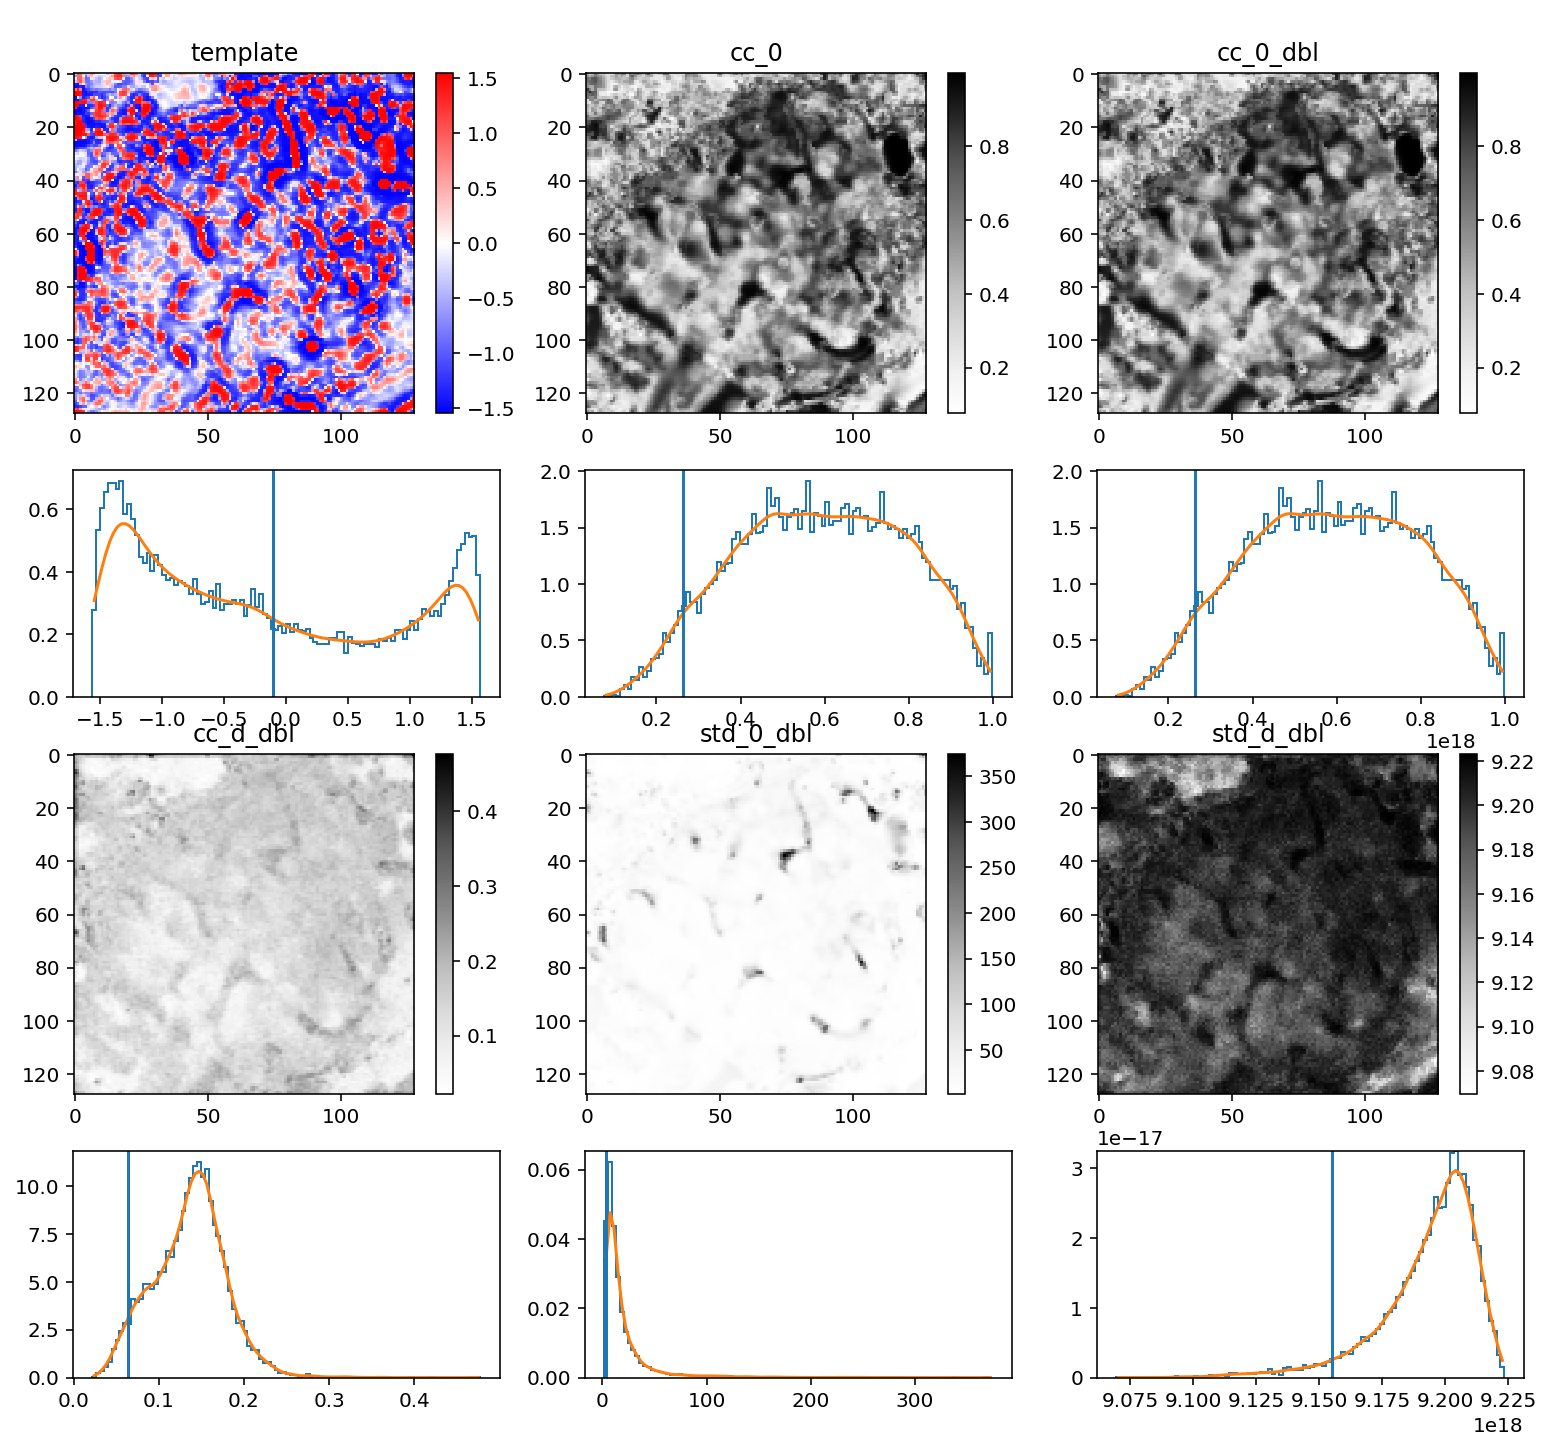

In [272]:
RegionSet = OrderedDict()
img2parcel = ["template","cc_0",
              "cc_0_dbl",
              "cc_d_dbl",
              "std_0_dbl",
              "std_d_dbl"
             ]
nc = 3
nr = int(np.ceil(len(img2parcel)/nc))*2
fig,axs = plt.subplots(nr,nc,figsize=(13,nr*3),gridspec_kw=dict(height_ratios = [3,2]*(nr//2)))
axs = axs.reshape((nr//2,2,nc)).transpose((0,2,1)).reshape((-1,2))
for j,terrain in enumerate(img2parcel):
    axu = axs[j,0]
    axd = axs[j,1]
    axu.set_title("\n"+terrain)
    print ("#"*20,terrain)
    x = images[terrain].astype('float')
    if terrain=="template":
        x = np.arctan(100*x)
    th = get_sep_th(x,ax=axd)
    if np.mean(x<th)<.05 or np.mean(x<th)>.2:
        th = np.percentile(x.flatten(),5)
    if terrain=="template":
        v = np.percentile(np.abs(x),99)*1
        im = axu.imshow(x,cmap="bwr", vmin=-v, vmax=v)
        th = -.1
    else:
        im = axu.imshow(x,cmap="Greys")
    plt.colorbar(im,ax=axu)
    axd.axvline(th)
    

    regions = Regions(x,th=th)
    print (len(regions.df),"rois inferred")
    regions.purge_lones(5)
    RegionSet[terrain] = regions

In [273]:
[(terrain,len(RegionSet[terrain].df)) for terrain in RegionSet]

[('template', 606),
 ('cc_0', 1062),
 ('cc_0_dbl', 1062),
 ('cc_d_dbl', 1630),
 ('std_0_dbl', 878),
 ('std_d_dbl', 2323)]

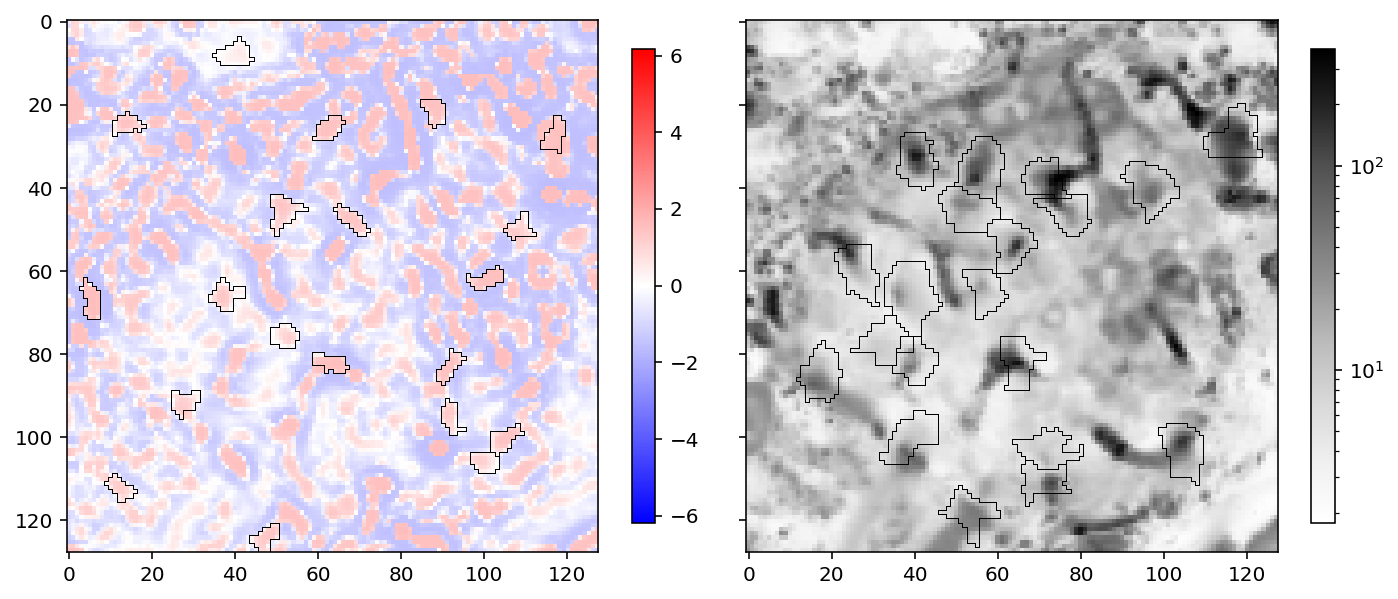

In [274]:
fig, axs = plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True)
for terrain,ax in zip(["template","std_0_dbl"],axs):
    
    regions = RegionSet[terrain]
    x = regions.image
    if terrain=="template":
        v = np.percentile(np.abs(x),99)*4
        im = ax.imshow(x,cmap="bwr", vmin=-v, vmax=v)
    else:
        im = ax.imshow(x,cmap="Greys",norm=LogNorm())
    plt.colorbar(im,ax=ax,shrink=.7)
    regions.plotEdges(ix = regions.df.sort_values("size",ascending=False).index[:20],separate=False,ax = ax, image=False,)

fig.tight_layout()

# expand (New)

## begin

In [278]:
regions = Regions(RegionSet['template'].image,-.1)

In [280]:
regions.purge_lones(5)

deleted 51 rois


In [279]:
regions.calcTraces(m_debleached)

(657, 8789)


In [281]:
C = regions.df
C.drop(index=C.query("size==1").index, inplace=True)

In [282]:
C.columns

Index(['peak', 'pixels', 'peakValue', 'size', 'edges', 'boundary', 'neighbors',
       'Nneighbors', 'trace'],
      dtype='object')

In [283]:
regions.update()

In [284]:
def getOutaCCs(movie,diff=False):
    from collections import defaultdict
    takenPixels = sum(C.pixels,[])
    nnpxList = OrderedDict()
    for roi in C.index:
        pixels = C.loc[roi,"pixels"]
        nnpxs = []
        for edge in C.loc[roi,"edges"]:
            edge = np.reshape(edge,(2,2))
            dimChange = np.diff(edge,axis=0)[0].astype(bool)
            assert edge[:,~dimChange].std()==0
            for d in [-.5,.5]:
                if edge[0,~dimChange]+d >=0:
                    nnpxs += [(int(edge[0,~dimChange]+d), int(edge[:,dimChange].mean()),)[::1 if dimChange[1] else -1]]
        nnpxs = [px for px in nnpxs if px not in takenPixels]
        for px in nnpxs:
            if px not in nnpxList:
                nnpxList[px] = []
            if roi not in nnpxList[px]:
                nnpxList[px] += [roi]

    nnpxList_inv = defaultdict(list)
    for px in nnpxList:
        for ix in nnpxList[px]:
            nnpxList_inv[ix] += [px]
    outaCCs = []
    for ix in nnpxList_inv:
        trace = C.loc[ix,"trace"]
        if diff:
            trace= np.diff(trace)
        for px in nnpxList_inv[ix]:
            try:
                tr = movie[(slice(None),) + px]
            except IndexError:
                continue
            if diff:
                tr = np.diff(tr)
            cc = np.corrcoef(trace,tr)[0,1]
            outaCCs += [[ix,px,cc]]
    outaCCs = pd.DataFrame(outaCCs,columns=["roi","px","cc"])
    return outaCCs

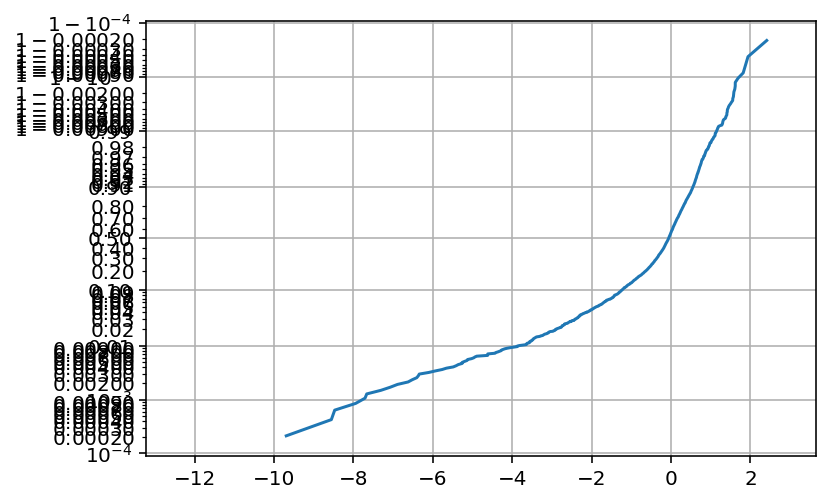

(571, 8789)


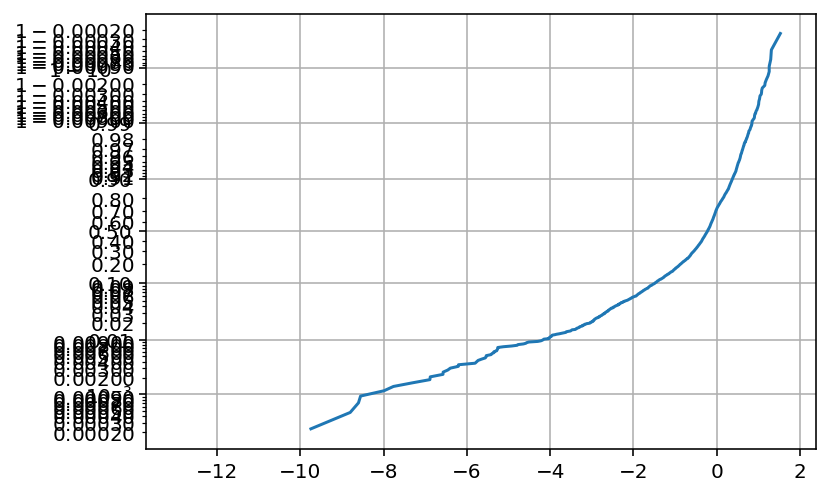

(571, 8789)


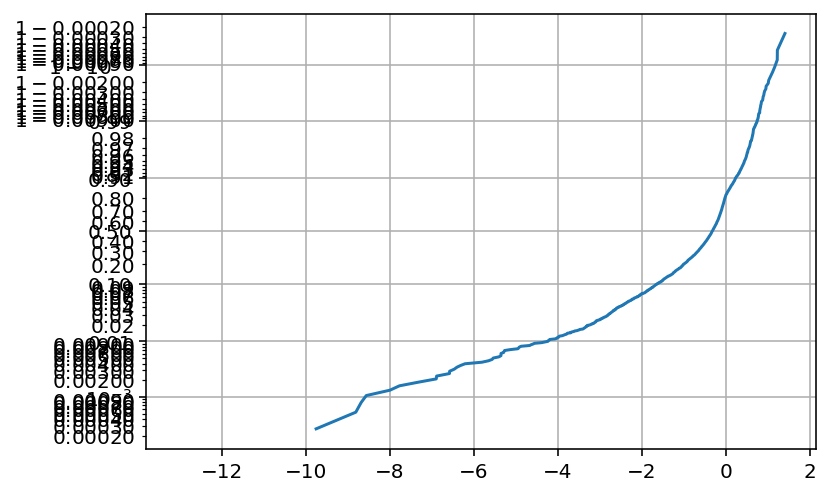

(571, 8789)


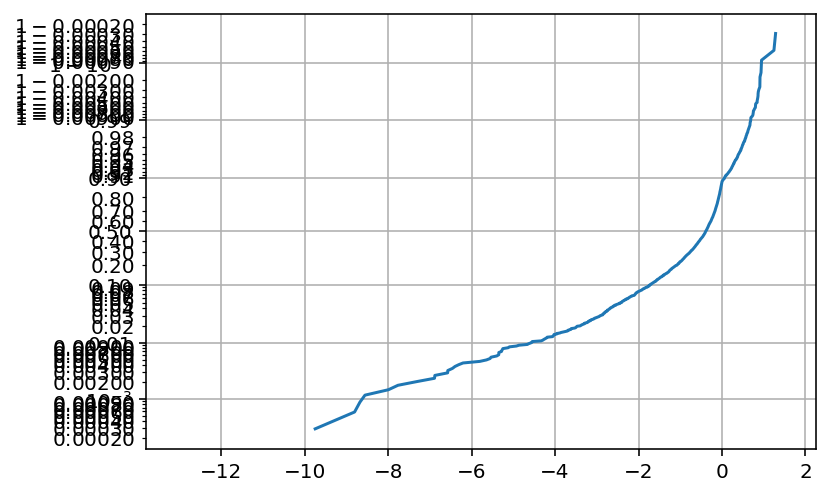

(571, 8789)


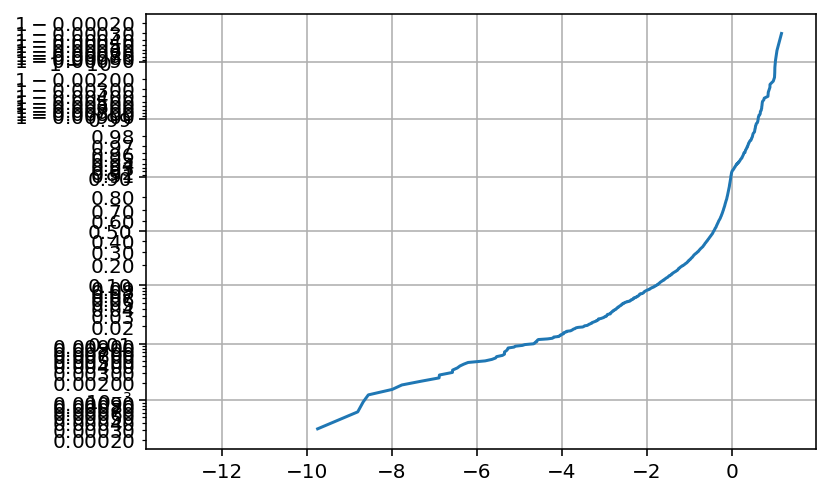

(571, 8789)


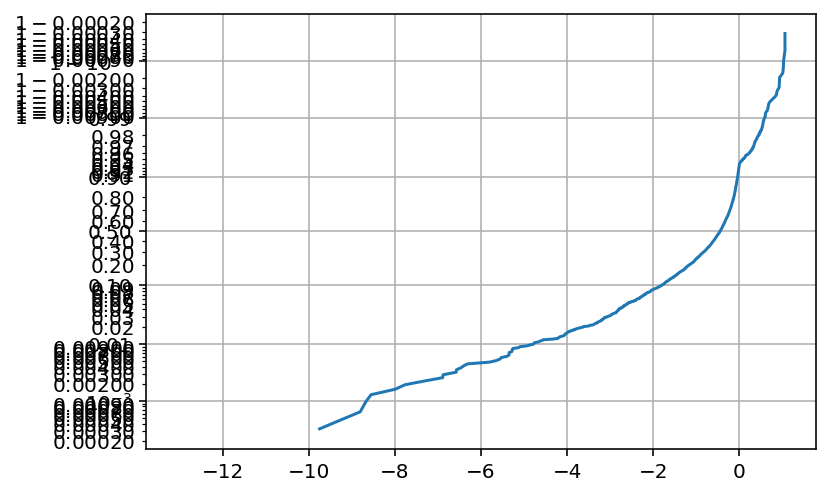

(571, 8789)


KeyboardInterrupt: 

In [285]:
# for nIter in range(10):
while True:
    regions.calcIntraCCs(m_debleached)
    outaCCs = getOutaCCs(m_debleached)

    stdmin = .1
    for i,row in outaCCs.iterrows():
        ccs = C.loc[row.roi,"intraCCs"]
        ccmean = np.mean(ccs)
        ccstd = np.std(ccs) if len(ccs)>2 else stdmin
        ccstd = np.sqrt(ccstd**2+stdmin**2)
        outaCCs.loc[i,"intraMean"] = ccmean
        outaCCs.loc[i,"intraStd"] = ccstd
        ccdist = (row.cc-ccmean)/ccstd
        outaCCs.loc[i,"ccdist"] = ccdist

    maxDists = np.array([df.ccdist.max() for px,df in outaCCs.groupby("px")])

    plt.plot(sorted(maxDists),np.linspace(0,1,len(maxDists)));
    plt.yscale("logit")
    plt.grid()
#     plt.show()
    if sum(maxDists>0)==0:break

    pixels = C.pixels.copy()

    for px,df in outaCCs.groupby("px"):
        ddf = df[df.ccdist>0]
        if not len(ddf):
            continue
        i = ddf.ccdist.idxmax()
        roi = df.loc[i,"roi"]
        pixels[roi] += [px]

    C["pixels"] = pixels

    regions.update(m_debleached)

## are these sensible

In [286]:
orig_regions = RegionSet["template"]

In [313]:
plt.hexbin?

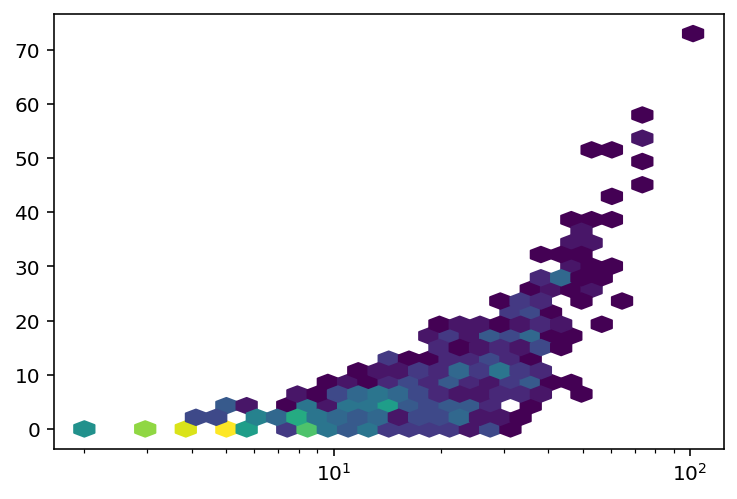

In [318]:
plt.hexbin(C["size"], C["changed"],mincnt=1,xscale="log",gridsize=30,yscale="symlog")

In [287]:
C["changed"] = C["size"]-orig_regions.df["size"][C.index]

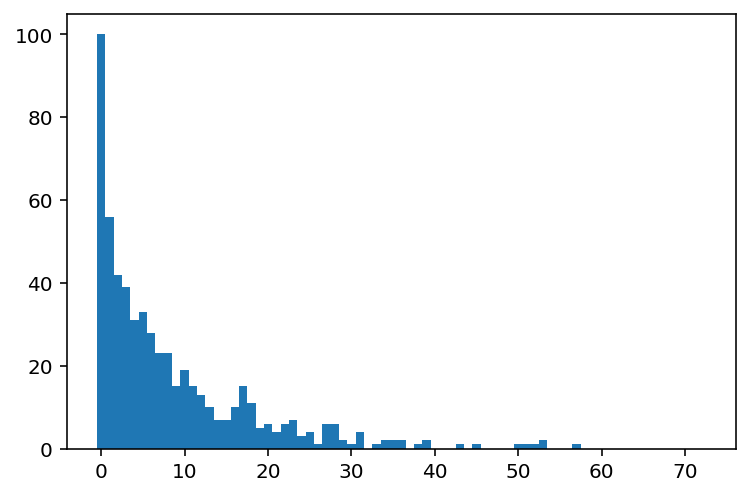

In [288]:
plt.hist(C["changed"], np.arange(C["changed"].max()+1)-.5);

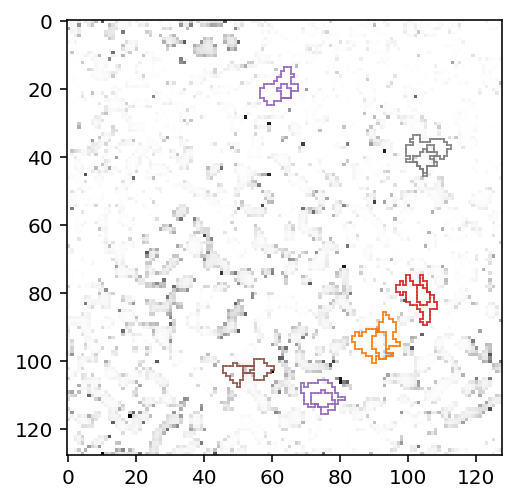

In [290]:
ax = plt.subplot(111)
indices = C.query("changed>50").index
regions.plotEdges(ix = indices,separate=True,ax=ax)
orig_regions.plotEdges(ix = indices,separate=True,ax=ax,image=False)

In [291]:
orig_regions.calcTraces(m_debleached)

(606, 8789)


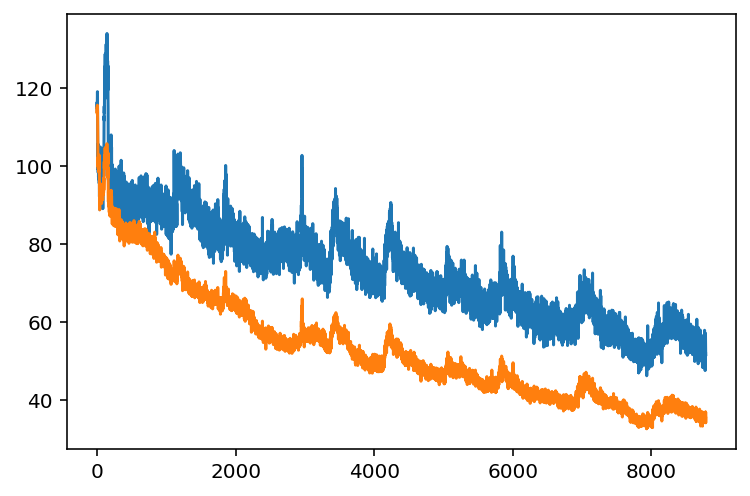

In [294]:
for i in indices[:1]:
    plt.plot(orig_regions.df.loc[i,"trace"])
    plt.plot(C.loc[i,"trace"])
#     plt.plot(orig_regions.df.loc[i,"trace"],orig_regions.df.loc[i,"trace"]-C.loc[i,"trace"],".")

In [295]:
len(C.loc[i,"pixels"]), len(orig_regions.df.loc[i,"pixels"]), 

(64, 12)

In [296]:
C.loc[i,"size"], orig_regions.df.loc[i,"size"]

(64, 12)

## Continue

In [432]:
import warnings

In [443]:
from scipy.optimize import OptimizeWarning

In [499]:
with warnings.catch_warnings():
    warnings.simplefilter("error",OptimizeWarning)
    dtr = []
    for tr in C.trace:
        td = decayfit(tr)
        dtr += [tr-td]

/home/jupyter-srdjan/srdjan_functs/numeric.py:13: RuntimeWarning:

divide by zero encountered in log

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numpy/lib/function_base.py:1273: RuntimeWarning:

invalid value encountered in subtract



In [500]:
C["detrended"] = dtr

In [501]:
crossCCdf = pd.DataFrame()
for i in C.index:
    ti = C.loc[i,"detrended"]
#     ti -= decayfit(ti)
    for j in C.loc[i,"neighbors"]:
        if j<i: continue
        tj = C.loc[j,"detrended"]
#         tj -= decayfit(tj)
        cc = np.corrcoef(ti,tj)[0,1]
        crossCCdf = crossCCdf.append(pd.Series([i,j,cc],index=["i","j","cc"]),ignore_index=True)

crossCCdf["i"] = crossCCdf["i"].astype(int)
crossCCdf["j"] = crossCCdf["j"].astype(int)

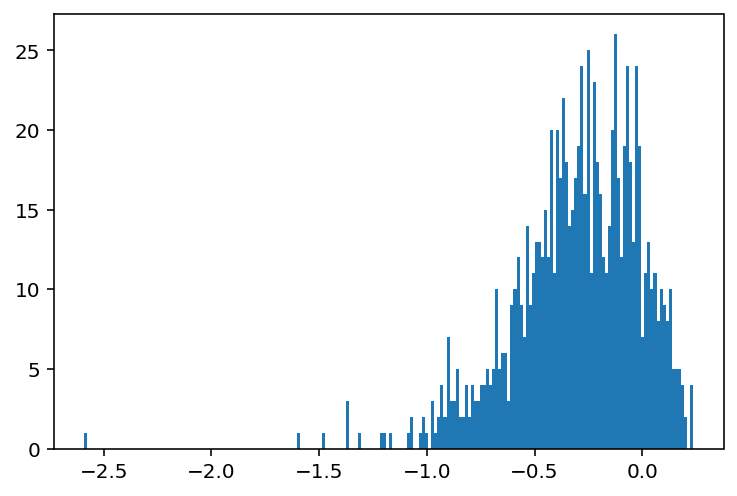

In [502]:
plt.hist(np.log10(1-crossCCdf.cc),200);

In [503]:
crossCCdf["size_i"] = [C.loc[roi,'size'] for roi in crossCCdf["i"]]
crossCCdf["size_j"] = [C.loc[roi,'size'] for roi in crossCCdf["j"]]

In [356]:
import plotly_express as plx

In [505]:
plx.scatter(crossCCdf.query("size_i<10 or size_j<10"),"size_i","size_j",marginal_y='histogram',color="cc")

153


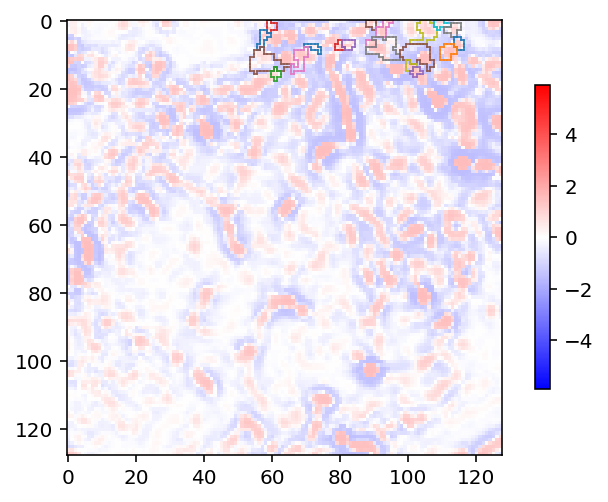

In [506]:
ax = plt.subplot(111)
x = np.arctan(30*template)
v = np.percentile(np.abs(x),99)*4
im = ax.imshow(x,cmap="bwr", vmin=-v, vmax=v)
plt.colorbar(im,ax=ax,shrink=.7)

df = crossCCdf.query("cc>0.4")
# df = df.query("(size_i<=5 and size_j>8) or (size_j<=5 and size_i>8)")
df = df.query("size_i<=10 or size_j<=10")
indices = np.unique(df[["i","j"]])
print (len(indices))
regions.plotEdges(ix=indices[:20],separate=True,ax=ax,image=False)
# for i,j in df[["i","j"]].values:
#     y,x = np.vstack(C.loc[[i,j],"peak"]).T
#     plt.plot(x,y,".-k",ms=1,lw=.3)

In [507]:
indices

array([ 13,  15,  18,  19,  26,  27,  30,  40,  43,  44,  46,  47,  50,
        51,  55,  56,  65,  88,  92,  94, 100, 105, 107, 111, 114, 117,
       119, 122, 126, 128, 141, 143, 145, 156, 191, 192, 201, 209, 210,
       214, 218, 222, 232, 251, 253, 254, 260, 264, 265, 268, 269, 273,
       276, 285, 286, 295, 306, 311, 316, 319, 323, 325, 328, 329, 335,
       338, 340, 342, 343, 344, 350, 352, 355, 356, 357, 361, 362, 363,
       368, 369, 372, 373, 374, 376, 377, 380, 384, 387, 391, 392, 395,
       397, 401, 407, 408, 417, 420, 426, 427, 430, 431, 434, 441, 444,
       448, 451, 454, 457, 461, 462, 470, 471, 473, 475, 479, 480, 481,
       488, 491, 496, 497, 501, 503, 509, 514, 523, 527, 529, 535, 537,
       550, 555, 563, 564, 565, 571, 573, 575, 576, 578, 593, 598, 599,
       622, 628, 630, 632, 636, 639, 647, 648, 652, 655])

In [ ]:
# pixels = pd.Series(map(list,C.pixels),index=C.index)
# del_indices = []

# cc_th = .9
# size_th = 10

# for _,row in crossCCdf.iterrows():
#     if row.cc<cc_th: continue
#     if row.size_i>size_th and row.size_j>size_th: continue
#     retain, absorb = (row.i,row.j) if row.size_i>row.size_j else (row.j,row.i)
#     print (absorb,"in",retain)
#     pixels[retain] += pixels[absorb]
#     del_indices += [absorb]
# C.pixels = pixels
# C.drop(index=del_indices,inplace=True)
# regions.update(m_debleached)

In [ ]:
# pixels = pd.Series(map(list,C.pixels),index=C.index)
# del_indices = []

# cc_th = .5

# for _,row in crossCCdf.iterrows():
#     if row.cc<cc_th: continue
#     retain, absorb = (row.i,row.j) if row.size_i>row.size_j else (row.j,row.i)
#     if C.loc[retain,"size"]<10: continue
#     if C.loc[absorb,"size"]>5: continue
#     print (absorb,"in",retain)
#     pixels[retain] += pixels[absorb]
#     del_indices += [absorb]
# C.pixels = pixels
# C.drop(index=del_indices,inplace=True)
# regions.update(m_debleached)

In [508]:
pixels = pd.Series(map(list,C.pixels),index=C.index)
del_indices = []

cc_th = .4

for _,row in crossCCdf.iterrows():
    if row.cc<cc_th: continue
    if (row.size_i<6 or row.size_j<6): 
        
        retain, absorb = (row.i,row.j) if row.size_i>row.size_j else (row.j,row.i)
        print (absorb,"in",retain)
        pixels[retain] += pixels[absorb]
        del_indices += [absorb]
C.pixels = pixels
C.drop(index=del_indices,inplace=True)
regions.update(m_debleached)

13.0 in 30.0
15.0 in 26.0
19.0 in 18.0
43.0 in 44.0
46.0 in 47.0
50.0 in 56.0
92.0 in 55.0
88.0 in 65.0
88.0 in 94.0
92.0 in 100.0
92.0 in 114.0
105.0 in 107.0
111.0 in 117.0
143.0 in 119.0
122.0 in 128.0
126.0 in 141.0
145.0 in 156.0
209.0 in 218.0
251.0 in 222.0
260.0 in 232.0
251.0 in 273.0
253.0 in 254.0
260.0 in 265.0
260.0 in 286.0
316.0 in 295.0
306.0 in 319.0
325.0 in 311.0
316.0 in 328.0
316.0 in 338.0
329.0 in 323.0
325.0 in 335.0
328.0 in 338.0
329.0 in 362.0
344.0 in 340.0
356.0 in 342.0
344.0 in 343.0
368.0 in 350.0
377.0 in 352.0
356.0 in 355.0
368.0 in 357.0
361.0 in 362.0
373.0 in 363.0
368.0 in 380.0
373.0 in 372.0
373.0 in 376.0
373.0 in 397.0
377.0 in 384.0
377.0 in 408.0
387.0 in 392.0
426.0 in 395.0
407.0 in 395.0
407.0 in 401.0
441.0 in 417.0
441.0 in 420.0
426.0 in 434.0
427.0 in 431.0
457.0 in 430.0
457.0 in 434.0
473.0 in 444.0
470.0 in 448.0
475.0 in 451.0
473.0 in 454.0
457.0 in 461.0
470.0 in 462.0
470.0 in 497.0
475.0 in 503.0
480.0 in 491.0
480.0 in 481.0


<BarContainer object of 63 artists>

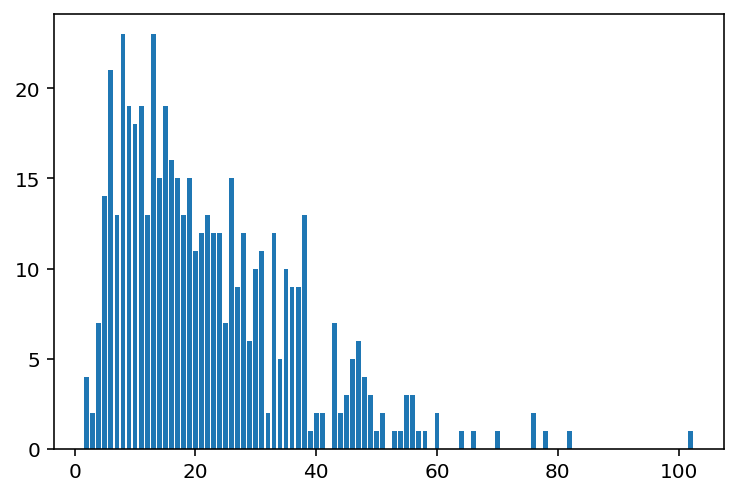

In [509]:
x = C["size"].value_counts().sort_index()
plt.bar(x.keys(),x)

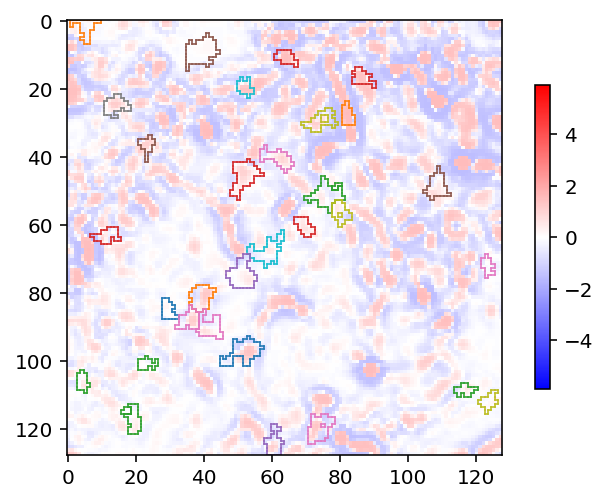

In [511]:
ax = plt.subplot(111)
x = np.arctan(30*template)
v = np.percentile(np.abs(x),99)*4
im = ax.imshow(x,cmap="bwr", vmin=-v, vmax=v)
plt.colorbar(im,ax=ax,shrink=.7)
regions.plotEdges(ix=C.query("size>15").index[::10],separate=True,ax=ax,image=False)


# expand?/reduce?

In [309]:
C = regions.df

In [310]:
def getOutaCCs(diff=False):
    from collections import defaultdict
    takenPixels = sum(C.pixels,[])
    nnpxList = OrderedDict()
    for roi in C.index:
        pixels = C.loc[roi,"pixels"]
        nnpxs = []
        for edge in C.loc[roi,"edges"]:
            edge = np.reshape(edge,(2,2))
            dimChange = np.diff(edge,axis=0)[0].astype(bool)
            assert edge[:,~dimChange].std()==0
            for d in [-.5,.5]:
                if edge[0,~dimChange]+d >=0:
                    nnpxs += [(int(edge[0,~dimChange]+d), int(edge[:,dimChange].mean()),)[::1 if dimChange[1] else -1]]
        nnpxs = [px for px in nnpxs if px not in takenPixels]
        for px in nnpxs:
            if px not in nnpxList:
                nnpxList[px] = []
            if roi not in nnpxList[px]:
                nnpxList[px] += [roi]

    nnpxList_inv = defaultdict(list)
    for px in nnpxList:
        for ix in nnpxList[px]:
            nnpxList_inv[ix] += [px]
    outaCCs = []
    for ix in nnpxList_inv:
        trace = C.loc[ix,"trace"]
        if diff:
            trace= np.diff(trace)
        for px in nnpxList_inv[ix]:
            try:
                tr = m_resized[(slice(None),) + px]
            except IndexError:
                continue
            if diff:
                tr = np.diff(tr)
            cc = np.corrcoef(trace,tr)[0,1]
            outaCCs += [[ix,px,cc]]
    outaCCs = pd.DataFrame(outaCCs,columns=["roi","px","cc"])
    return outaCCs

In [311]:
# plt.figure(figsize=(10,10))
# ax = plt.subplot(111)
# x = np.arctan(sc*template)
# v = np.percentile(np.abs(x),99)*4
# im = ax.imshow(x,cmap="bwr", vmin=-v, vmax=v)
# # plt.imshow(template.T,cmap="Greys")
# ax.scatter(*np.array(list(nnpxList.keys())).T[::-1], marker="s",s=4,c=list(map(len,nnpxList.values())), cmap="jet")
# regions.plotEdges(ix = C.query("size>10").index,ax=ax,image=False)

In [312]:
regions.calcIntraCCs(diff=True)

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning:

invalid value encountered in true_divide

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning:

invalid value encountered in true_divide



In [313]:
C["maxIntraCCs"] = C.intraCCs.apply(max)
C["minIntraCCs"] = C.intraCCs.apply(min)

In [314]:
px.scatter(C,
           "minIntraCCs",
           "maxIntraCCs",
#            "peakValue",
           size="size",
           color="size",
#            log_y=True,
#            marginal_x="histogram",
#            log_x=True,
          )

In [315]:
absMinInstraCC = C.query("size==2").minIntraCCs.min()

In [320]:
C["NrightPx"] = C.intraCCs.apply(lambda xi: sum([el>=absMinInstraCC for el in xi]))

In [321]:
px.scatter(C,
           "size",
           "NrightPx",
#            "peakValue",
           size="size",
#            color="size",
#            log_y=True,
#            marginal_x="histogram",
#            log_x=True,
          )

# Try Matrix Factorization

In [325]:
roi = C["size"].idxmax()

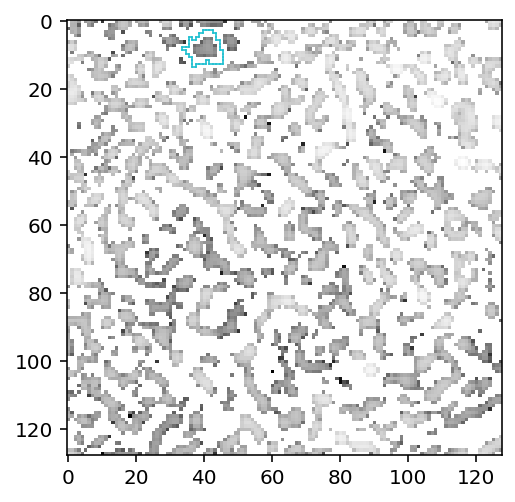

In [328]:
regions.plotEdges(ix=[roi],separate=True)

In [329]:
pixels = C.loc[roi,"pixels"]

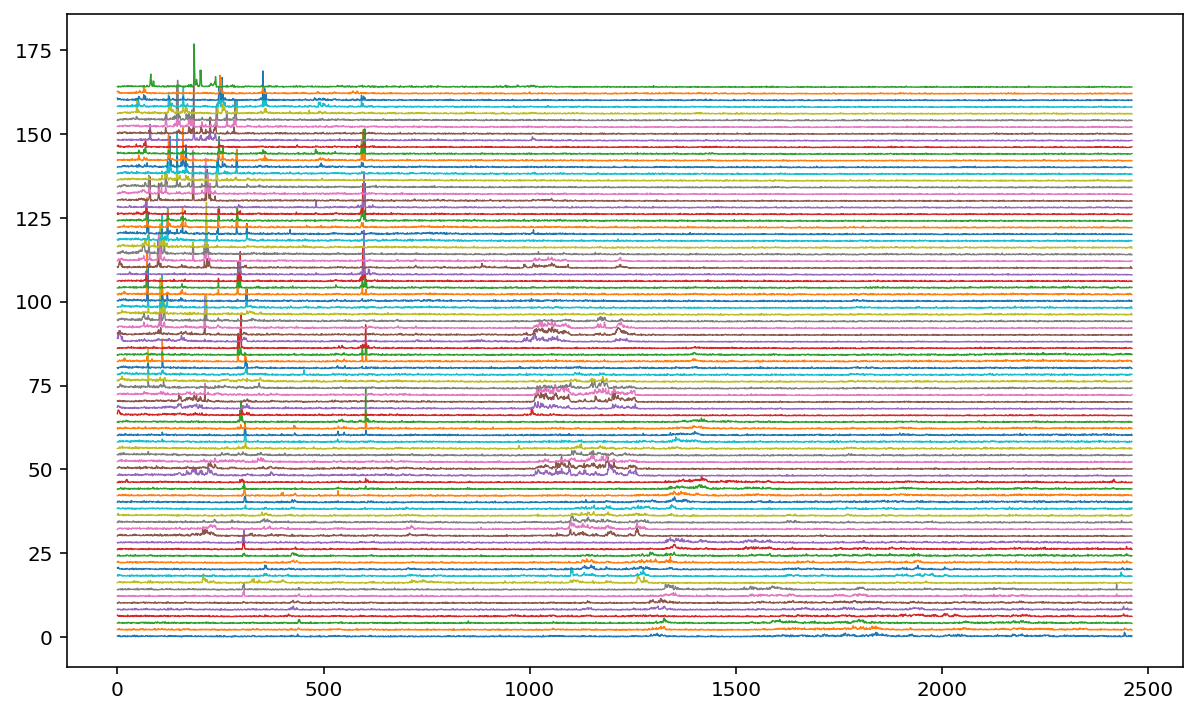

In [338]:
plt.figure(figsize=(10,6))
for j,px in enumerate(pixels):
    plt.plot(m_resized[::10,px[0],px[1]]+j*2,lw=.7)

In [476]:
def dMatrix(x): return 1-np.corrcoef(x)
Xdata = np.vstack([ rebin(m_resized[:,px[0],px[1]],10) for px in pixels ])
print (Xdata.shape)
# Xdata = np.log10(1e-2+Xdata)
# clusterRes = clusterCutAndPlot(Xdata,function=agglomerativeLinkage,functionArgs=(dMatrix,))

(83, 2461)


In [442]:
from collections import defaultdict

In [384]:
# from sklearn.model_selection import KFold
from sklearn.decomposition import NMF

In [ ]:
errs = pd.DataFrame()

In [529]:
for ncomponents in range(10,14):
    for alpha in 10**np.arange(-4,0,.5):
        nmf = NMF(ncomponents,l1_ratio=1,alpha=alpha)
        ntest = Xdata.size//20
        for isplit in range(30):
            np.random.seed(isplit)
            itest = np.random.randint(Xdata.size,size=ntest,)
            itest = np.repeat(itest,2).reshape((ntest,2)).T
            itest[0] = itest[0]//Xdata.shape[1]
            itest[1] = itest[1] %Xdata.shape[1]
            itest = tuple(itest)

            X_train = Xdata.copy()
            X_train[itest] = np.random.permutation(X_train[itest])

            nmf.fit(X_train);

            W = nmf.transform(X_train)

            Xfit = nmf.inverse_transform(W)
            x = (Xdata-Xfit)**2
            toterr = np.sum(x)
            testerr = np.sum(x[itest])
            trainerr = toterr-testerr
            errs = errs.append(pd.Series([isplit,ncomponents,alpha, trainerr, "train", nmf],
                                         index=["split","ncomponents","reg","err","flag","nmf"]
                                        ),ignore_index=True)
            errs = errs.append(pd.Series([isplit,ncomponents,alpha, testerr ,  "test", nmf],
                                         index=["split","ncomponents","reg","err","flag","nmf"]
                                        ),ignore_index=True)

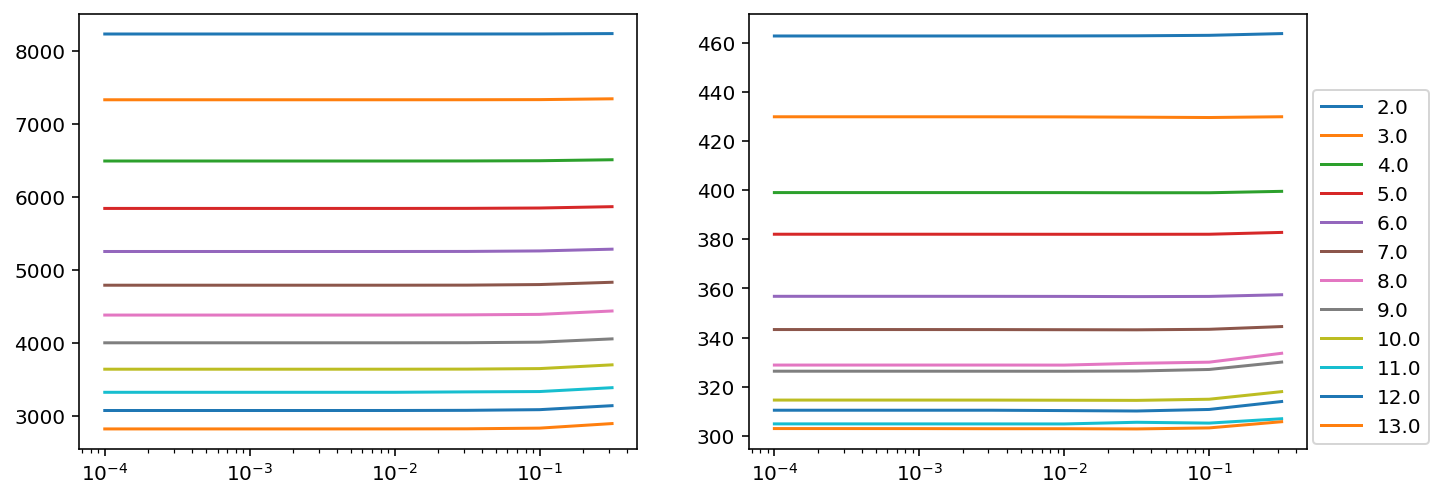

In [531]:
fig,axs = plt.subplots(1,2,figsize=(11,4), sharex=True, sharey=False)
for ax, flag in zip(axs, ["train","test"]):
    df = errs.query(f"flag=='{flag}'")
    for nC,ddf in df.groupby("ncomponents"):
        x = ddf.reg.unique()
        y = np.array([ dddf.err.mean()  for reg,dddf in ddf.groupby("reg")])
        ax.plot(x,y,label=nC)
plt.xscale("log")
ax.legend(loc=(1.01,.01))
# plt.yscale("symlog")

In [532]:
W = nmf.transform(Xdata)

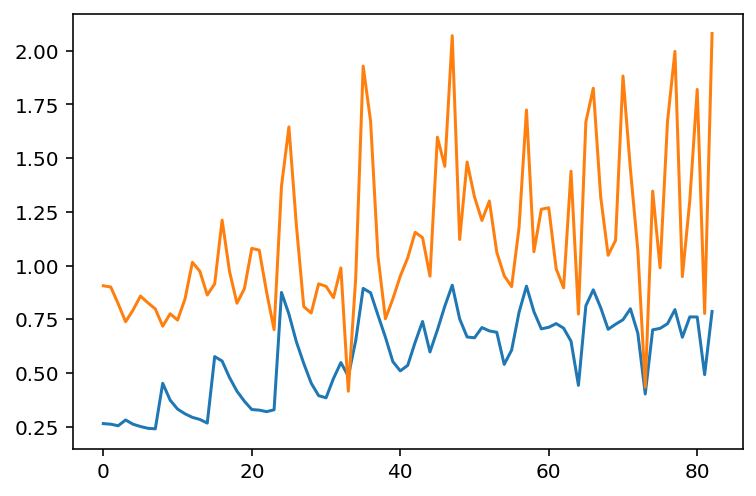

In [536]:
plt.plot(W.mean(axis=1))
plt.plot(W.std(axis=1))

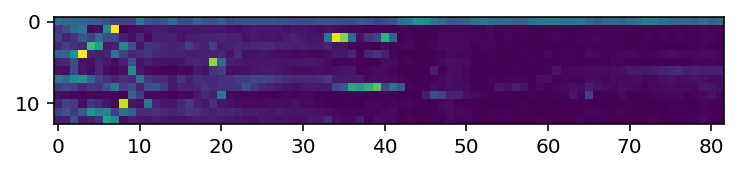

In [533]:
plt.imshow(rebin(nmf.components_,30,axis=1))

In [537]:
np.mean(W!=0,axis=0)

array([1.        , 0.59036145, 0.71084337, 0.63855422, 0.57831325,
       0.53012048, 0.46987952, 0.73493976, 0.79518072, 0.36144578,
       0.48192771, 0.61445783, 0.40963855])

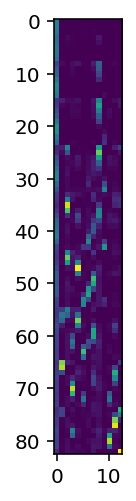

In [538]:
plt.imshow(W)

In [506]:
[ [ for nmf in ddf.nnmf]  for reg,ddf in df.groupby("reg")]

True

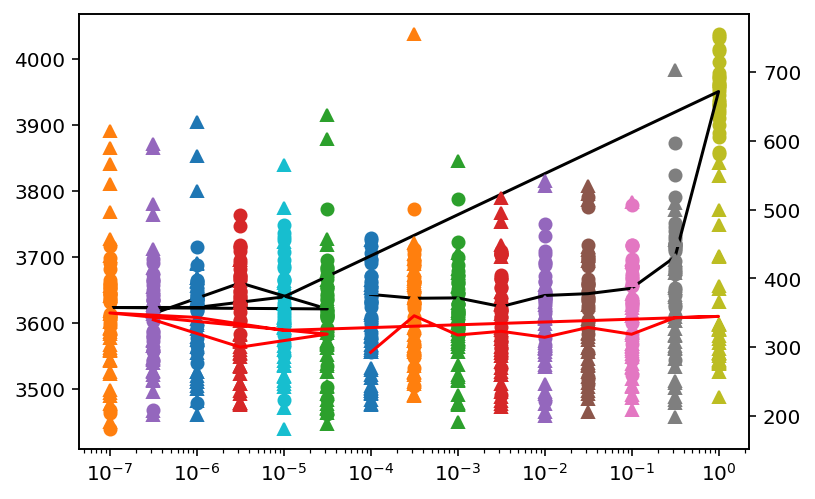

In [490]:
B = OrderedDict([("train",[]),("test",[])])
atrain = plt.subplot(111)
atest  = atrain.twinx()
for k in sorted(errs.keys()):
    if "train" in k:
        ax = atrain
        m = "o"
        b = B["train"]
    else:
        ax = atest
        m = "^"
        b = B["test"]
    x = float(k.split("_")[1])
    y = errs[k]
    b += [[x,np.mean(y)]]
    x = [x]*len(y)
    ax.plot(x,y,m)
ax.set_xscale("log")
for ax,k,c in zip([atrain,atest],B,"kr"):
    ax.plot(*np.array(B[k]).T,c=c)
#     plt.twinx()
#     plt.plot([])

In [488]:
np.argmin(np.array(B[k]).T[1])

0

In [481]:
# plt.imshow(X_train)

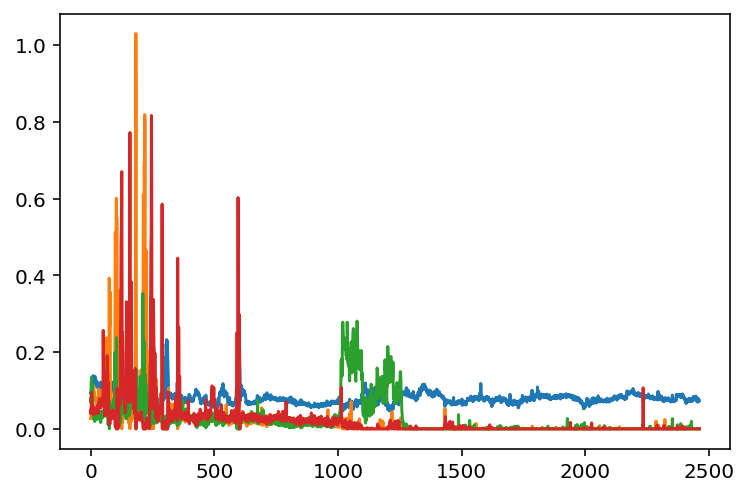

In [482]:
for com in nmf.components_:
    plt.plot(com)

In [ ]:
itrain = np.random.choice(np.arange)

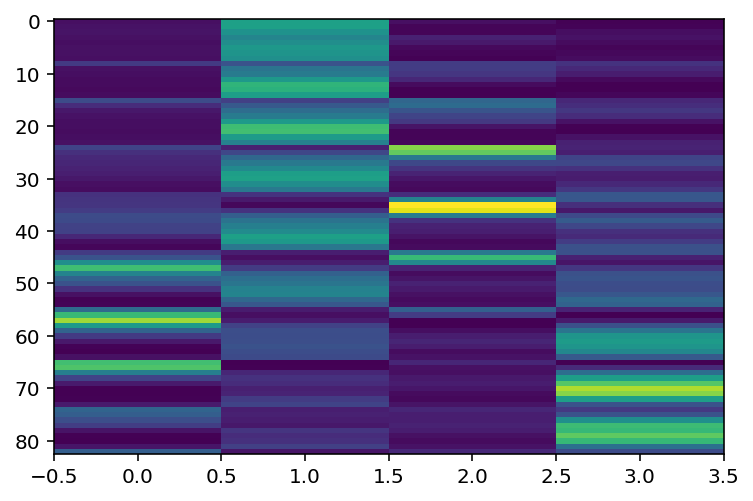

In [383]:
plt.imshow()
plt.gca().set_aspect("auto")

In [238]:
# C.drop(index=C.query("maxIntraCCs<.3").index,inplace=True)
# regions.update()

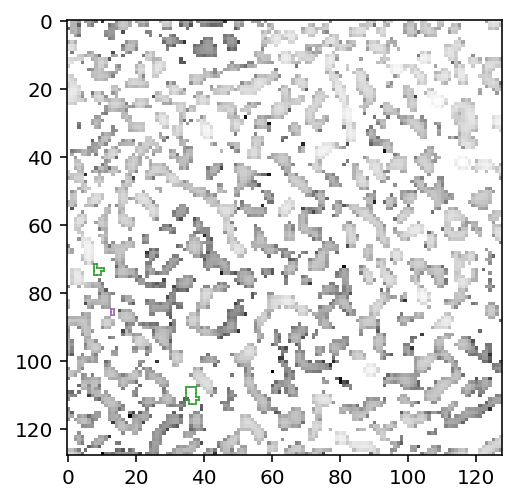

In [254]:
regions.plotEdges(ix = C.query("maxIntraCCs>.9 and peakValue<.001").index,separate=True)

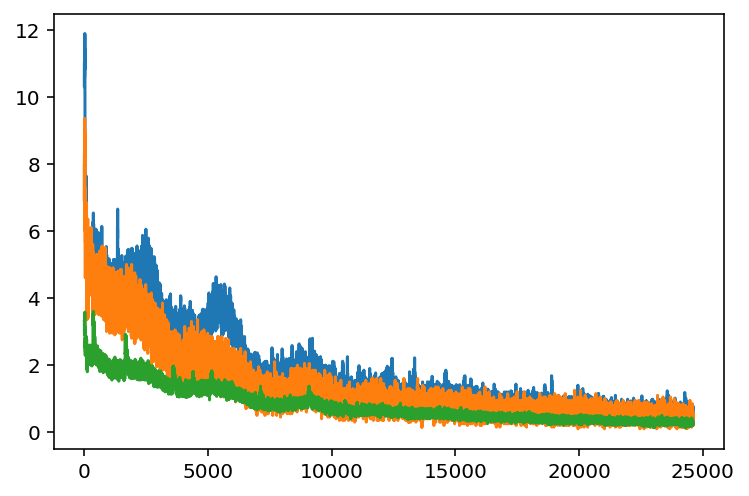

In [255]:
for i in C.query("maxIntraCCs>.9 and peakValue<.001").index:
    plt.plot(C.loc[i,"trace"])

In [165]:
outaCCs = getOutaCCs()

In [167]:
# for px,df in outaCCs.groupby("px"):
#     if len(df)>2:
#         break

In [168]:
for i,row in outaCCs.iterrows():
    break

In [169]:
roi = row.roi

In [153]:
%matplotlib notebook

<IPython.core.display.Javascript object>


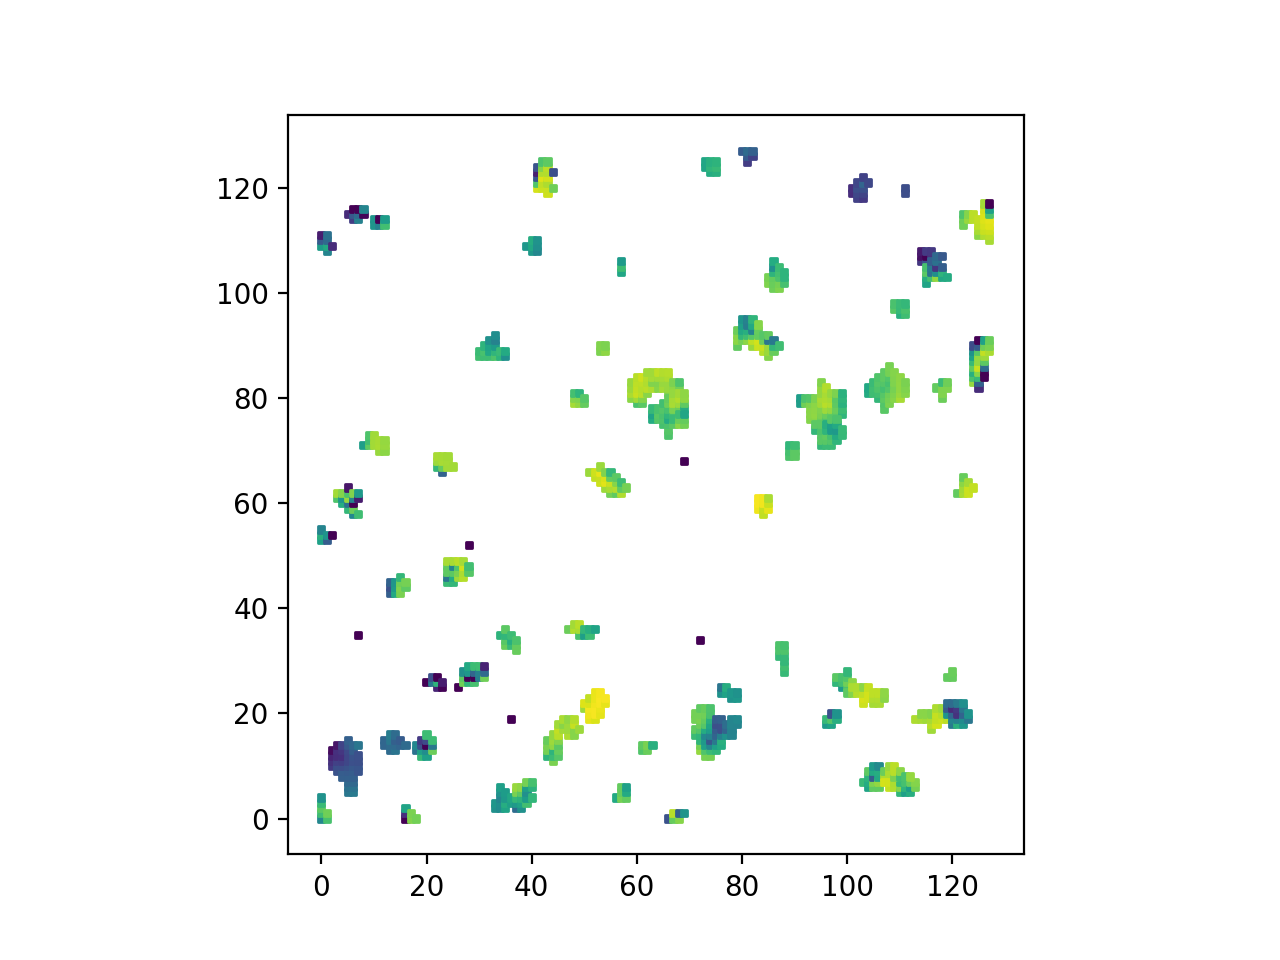

In [172]:
for roi in C.index[::10]:
    c = np.array(C.loc[roi,"intraCCs"])
    c[c<0] = 0
    # c = c-c.min()
    # c = c/c.max()
    plt.scatter(*np.array(C.loc[roi,'pixels']).T,marker='s',c=plt.cm.viridis(c),s=5)
plt.gca().set_aspect("equal")

In [175]:
%matplotlib inline

In [239]:
# regions.update()

# Scrambled image

In [187]:
# Fourier transforms
FT = np.fft.fftn(template)
# amplitudes
FA = np.abs(FT)


In [188]:
im_whitened = np.real_if_close(np.fft.ifftn(FT/FA))

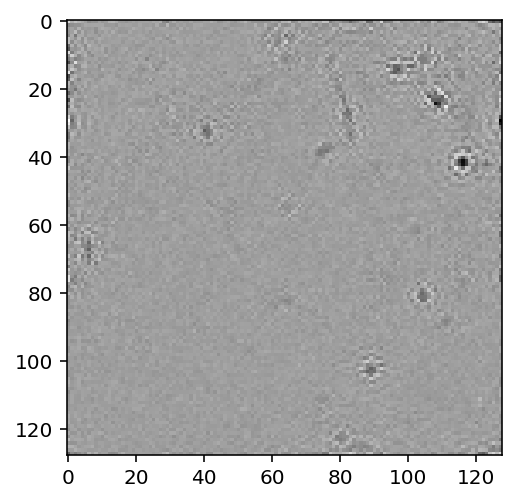

In [190]:
plt.imshow(im_whitened,cmap="Greys")

In [191]:
phase = np.angle(FT)

In [192]:
phase_scrambled = np.reshape(
    np.random.choice(phase.flatten(), size=len(phase.flatten()), replace=False),
    np.shape(phase))
phase_scrambled.shape

(128, 128)

In [193]:
FT_scambled = FA*np.exp(1j*phase_scrambled)
FT_scambled.shape

(128, 128)

In [194]:
im_ph_scrambled = np.real_if_close(np.fft.ifftn(FT_scambled))


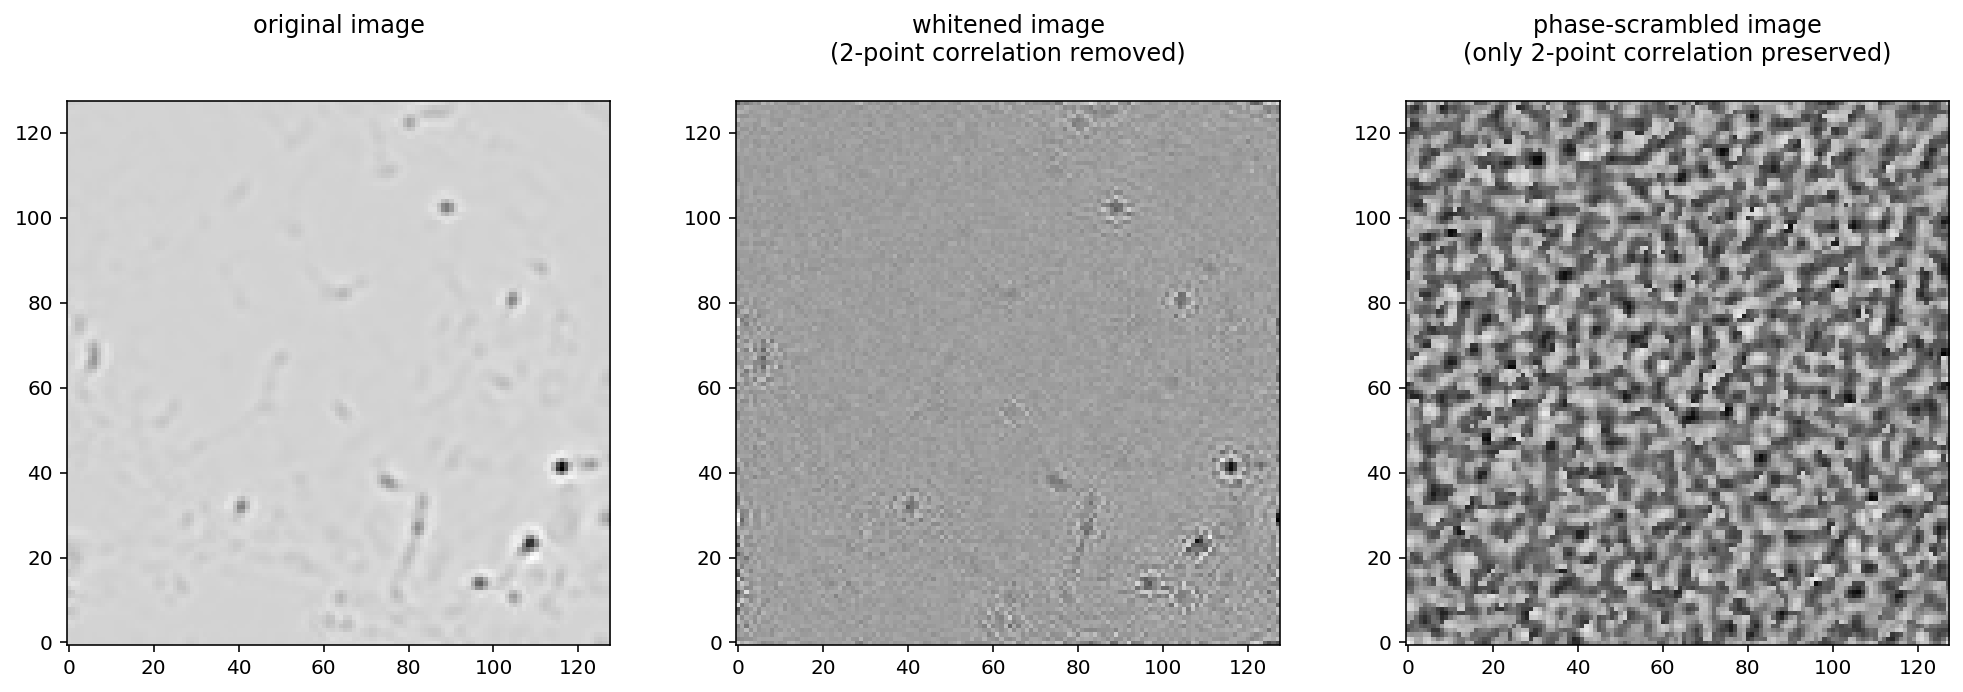

In [219]:
plt.figure(figsize=(17,5))
plt.subplot(1,3,1)
plt.title('original image\n\n')
plt.imshow(template,interpolation="nearest", cmap=plt.cm.Greys, origin='bottom')
plt.subplot(1,3,2)
plt.title('whitened image\n(2-point correlation removed)\n')
plt.imshow(im_whitened,interpolation="nearest", cmap=plt.cm.Greys, origin='bottom')
plt.subplot(1,3,3)
plt.title('phase-scrambled image\n(only 2-point correlation preserved)\n')

plt.imshow(im,interpolation="nearest", cmap=plt.cm.Greys, origin='bottom')

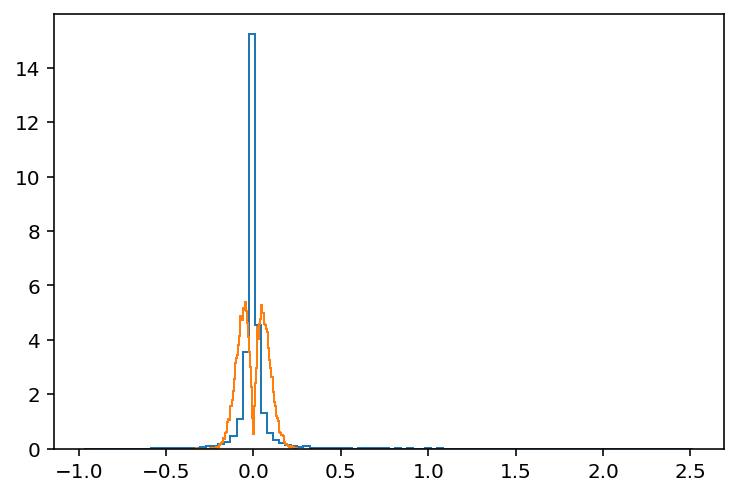

In [233]:
# plt.hist(pow(np.real(im_ph_scrambled).flatten(),1.5),100, histtype="step",density=True);
# # plt.hist(np.abs(im_ph_scrambled).flatten(),100, histtype="step",density=True);
# # plt.hist(np.imag(im_ph_scrambled).flatten(),100, histtype="step",density=True);
im = np.sign(np.real(im_ph_scrambled))*np.abs(im_ph_scrambled)**1.1
plt.hist(template.flatten(),100, histtype="step",density=True);
plt.hist(im.flatten(),100, histtype="step",density=True);

In [234]:
rr = Regions(im,th=0)

In [235]:
rr.purge_lones(4)

deleted 30 rois


In [236]:
rr.df.shape

(1090, 8)

In [232]:
regions.df.shape

(735, 11)

In [237]:
del rr

# Filtering and further

In [634]:
from general_functions import multi_map

In [660]:
# prepare m_analys for faster analysis.
# (For final presentation we can always go back to original movie.)
m_analysis = m_orig.copy()

In [630]:
# First, introduce some gaussian blur
m_analysis.gaussian_blur_2D(3,3,.5,.5);

# Then, resample to lower frequency (for analyses downstream to go much faster)
newFreq = 30
n_rebin = int(m_orig.fr/newFreq)
m_analysis = rebin(m_analysis,n_rebin, norm=False)
m_analysis.fr = m_orig.fr/n_rebin

In [661]:
# dt = .333
ironScale = 3
wIron = int(ironScale*m_analysis.fr)
if wIron%2==0:
    wIron += 1
print(wIron)
filterPars = (wIron,wIron,50.,2)

253


In [662]:
regions.update(m_analysis)

(517, 246108)


In [663]:
%%capture
lowPass(regions.df["trace"].iloc[0],*filterPars)
runningStd(regions.df["trace"].iloc[0],wIron)

In [664]:
def iterf(x_):
    return lowPass(x_,*filterPars)

C["slower_%g"%ironScale] = multi_map(iterf,C["trace"].values,processes=15)
# C["slower_%g"%ironScale] = [iterf(tr) for tr in C.loc[:,"trace"]]

In [665]:
C["faster_%g"%ironScale] = [C.loc[i,"trace"] - C.loc[i,"slower_%g"%ironScale] for i in C.index]

In [666]:
def iterf(x_):
    mad2std = 1.4826
    out = mad2std*percFilter(np.abs(x_),50.,wIron)
    out = runningAverage(out,wIron)
    return out

C["faster_%g_std_mad"%ironScale] = multi_map(iterf,C["faster_%g"%ironScale].values,processes=15)

## Check is the std sensible

In [ ]:
# def iterf(x_):
# #     mad2std = 1.4826
# #     out = mad2std*percFilter(np.abs(x_),50.,wIron)
# #     out = runningAverage(out,wIron)
#     out = runningStd(x_,wIron)
#     return out

# C["faster_%g_std"%ironScale] = multi_map(iterf,C["faster_%g"%ironScale].values,processes=15)

In [639]:
# C["faster_%g_std1"%ironScale] = [(C.loc[i,"slower_%g"%ironScale]/C.loc[i,"size"])**.5 for i in C.index[:]]

In [640]:
# iis = C.index[::10]
# tmp = pd.DataFrame(OrderedDict([
#     (k, np.concatenate([C.loc[i,k][::100] for i in iis]))
#     for k in [
#         "faster_%g_std1"%ironScale,
#         "faster_%g_std"%ironScale ,
#         "faster_%g_std_mad"%ironScale 
#     ]
# ]))

# fig, axs = plt.subplots(1,3,figsize=(10,4) ,sharex=True,sharey=True)
# ia = 0
# for i in range(3):
#     for j in range(i+1,3):
#         ax = axs[ia]
#         k1,k2 = tmp.columns[i],tmp.columns[j]
#         ax.hexbin(tmp[k1],tmp[k2],bins="log", mincnt=1,xscale="log",yscale="log")
#         ax.set_xlabel(k1)
#         ax.set_ylabel(k2)
#         ax.plot([1,50],[1,50],"C1",lw=.7)
#         ia +=1 
#         ax.set_aspect("equal")

# Investigate results

In [641]:
# plotting definition
def plotInteresting(investigateIndex_, onlyImage=False, figsize = (10,10)):
    fig, axs = plt.subplots(1,2,figsize=[figsize[0],figsize[1]/2], sharex=True, sharey=True)
    for ax,im in zip(axs,["std_dres","template"]):
        showImage = images[im].astype("float")
        if im=="std_dres":
            ax.imshow(.01+showImage,cmap="Greys",norm=LogNorm(),vmax=showImage.max()*10)
        else:
            x = np.arctan(30*showImage)
            v = np.percentile(np.abs(x),99)*4
            im = ax.imshow(x,cmap="bwr", vmin=-v, vmax=v)
        regions.plotEdges(ix=investigateIndex_,separate=True,image=False, ax=ax)
        regions.plotPeaks(ix=investigateIndex_,image=False, ax=ax,labels=True)
    fig.show()
    
    if onlyImage: return None

    fig, axs = plt.subplots(2,1,figsize=figsize, sharex=True)
    ia = 0
    n = 1
    ns = 2

    # inax = inset_axes(axs[0],
    #                     width="30%", # width = 30% of parent_bbox
    #                     height=1.2, # height : 1 inch
    #                     loc=2)
    # showImage = images["std_dres"].astype("float")
    # inax.imshow(.1+showImage,cmap="Greys",norm=LogNorm(),vmax=showImage.max()*10)
    # regions.plotEdges(ix=investigateIndex_,separate=True,ax=inax)
    t = rebin(time,n)
    for roi in investigateIndex_:
        x  = rebin(C.loc[roi,"trace"],n)
        xf = rebin(C.loc[roi,"faster_%g"%ironScale],n)
        xsd= rebin(C.loc[roi,"faster_%g_std"%ironScale],n)/n**.5
        xs = rebin(C.loc[roi,"slower_%g"%ironScale],n)
        eventFilter = posRender[np.where(C.index==roi)[0][0]]

        xsd= xsd/xf.std()
        xf = xf/xf.std()

        c  = "C%i"%(roi%10)
        axs[0].plot(t,x [::],c=c,lw=.4,alpha = .3)
        axs[0].plot(t,xs[::],c=c,lw=.7,alpha = 1)
        axs[0].plot(t[eventFilter],xs[eventFilter],".",c=c,ms=2,alpha = .2)
        yoffset = 13*ia
        axs[1].plot(t,xf[::]+yoffset,c=c,lw=.3)
        axs[1].plot(t,+ns*xsd[::]+yoffset,c=c,lw=.7)
        axs[1].plot(t,-ns*xsd[::]+yoffset,c=c,lw=.7)
        axs[1].axhline(yoffset,color=c,label=roi)
        axs[1].text(0,yoffset,str(roi)+" ",fontdict={"color":c},ha="right",va="center")
        axs[0].text(0,xs[0],str(roi)+" ",fontdict={"color":c},ha="right",va="center")
    # axs[1].legend(loc=(1.01,.01))
    # #     x,y = C.loc[roi,"peak"]#np.mean(C.loc[i,"pixels"],axis=0)
    # #     inax.plot(x,y,"o",mfc="none",ms=C.loc[i,"size"]**.5/2,c=c,mew=.3)
    #     bb = list(C.loc[roi,"boundary"])
    #     bb += [bb[0]]
    #     x,y = np.array(bb).T
    #     inax.plot(x,y,c=c,lw=.5)
        ia += 1
    # yl = axs[0].get_ylim()[1]
    # axs[0].set_ylim(None,yl*1.2)

    # plt.xticks([])
    # plt.yticks([])
    fig.tight_layout()
    fig.show()

In [667]:
valName = "faster_%g"%ironScale
stdName = "faster_%g_std_mad"%ironScale

In [668]:
if sum([np.isnan(x).sum() for x in  C[stdName]]):
    nZerosStd = np.array([(x==0).sum() for x in  C[stdName]])

    plt.figure()
    plt.plot(sorted(nZerosStd),np.arange(len(C)),".-")
    plt.xscale("symlog")
    plt.show()
    toDrop = C.index[nZerosStd>10]
    x = input("do you really want to remove these?")
    if x[0].lower()=="y":
        C.drop(index=toDrop,inplace=True)

In [681]:
try:
    toDrop = C.query("negZmean<1e-5").index
    x = input("do you really want to remove these?")
    if x[0].lower()=="y":
        C.drop(index=toDrop,inplace=True)
        print ("dropped %i rois"%len(toDrop))
except:
    pass

do you really want to remove these?n


In [669]:
stdMin = np.vstack(C[stdName]).min()/10

In [670]:
zscore = np.vstack(C[valName])/(stdMin+np.vstack(C[stdName]))
# print ((~np.isfinite(zscore)).sum())
# print (np.nanmin(zscore), np.nanmax(zscore))

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in true_divide

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

invalid value encountered in true_divide



In [671]:
zth = 3.
negRender = zscore<-zth
posRender = zscore>+zth

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in less

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

invalid value encountered in greater



In [672]:
C["negZmean"] = negRender.mean(axis=1)
C["posZmean"] = posRender.mean(axis=1)

In [673]:
C["lognegZmean"] = np.log10(C["negZmean"])
C["logposZmean"] = np.log10(C["posZmean"])

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning:

divide by zero encountered in log10



In [674]:
C["logSlowMean"] = np.log10(C["slower_%g"%ironScale].apply(np.mean))

In [675]:
# investigateIndex = np.random.choice(C.query("size>=10").index,20)
investigateIndex = np.random.choice(C.query("size>1 and posZmean>0.0").index,10)
investigateIndex = np.unique(investigateIndex)
# investigateIndex = np.concatenate([[272,649,599,580], investigateIndex])
print (len(investigateIndex))
C['invest'] = [1 if i in investigateIndex else 0 for i in C.index]

10


In [676]:
plx.scatter(C,"lognegZmean","logposZmean",size="size",
#            log_x=True,log_y=True,
           hover_name=C.index,
#            color=None if "invest" not in C else C["invest"],
           color=C["logSlowMean"],
#            facet_col="invest",
           height=600,width=700,
           marginal_x="histogram",
           marginal_y="histogram",
          )

In [677]:
ironScale

3

In [653]:
npzFile

'local_data/Sandra/2020_01_14/Experiment45c/Experiment45c_1_Series003-004_motcor.npz'

# Saving

In [592]:
# plt.figure()
# plt.hist(np.diff(np.where(eventFilter)[0]))

In [594]:
regionSaveName = baseName+"_regions.pkl"

In [595]:
import pickle

In [597]:
regions.std_dres_image = images["std_dres"].astype(float)

In [601]:
if os.path.isfile(regionSaveName):
    print (regionSaveName, "exists. Please choose a different name.")
else:
    with open(regionSaveName,"wb") as f:
        pickle.dump(regions,f)

In [602]:
regionSaveName

'local_data/Sandra/2020_01_14/Experiment45b/Experiment45b_1_Series006-008_regions.pkl'

# Show Movie

In [297]:
timeSlice = slice(int(len(m_orig)*.0),int(len(m_orig)*1))

nTimeFrames = 200
nRebinShow = len(m_orig[timeSlice])//nTimeFrames
border = np.ones((nTimeFrames,1,m_orig.shape[-1]))*m_orig.max()
m2show = rebin(m_orig[timeSlice].astype(np.float32), nRebinShow)
# m2show = concatenate([
#     rebin(m_orig[timeSlice], nRebinShow),
#     border,
#     rebin(m_corr[timeSlice], nRebinShow),
# ],axis=1)

# showMovie(np.log(1+m2show),figsize=(13,6))

In [298]:
m2show.min(), m2show.max(), np.percentile(m2show,99.5)

(movie(0., dtype=float32), movie(64.4489, dtype=float32), 13.669666371345517)

In [301]:
# showMovie(np.log(.1+m2show),figsize=(7,6))

In [302]:
from sys import getsizeof